In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
    RE_MAPS = os.path.join(RE, "enh_maps")
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"

# nomination dataframe
NOMS = os.path.join(PATH, "GABA_GLUT_DF.for.noms.tsv")
CANDIDATE_REGIONS = os.path.join(PATH, "CANDIDATE.SIG.REGIONS.GABA.GLUT.tsv")

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
df = pd.read_csv(NOMS, sep='\t')
candidates = pd.read_csv(CANDIDATE_REGIONS, sep='\t')

df = pd.merge(df, candidates[['coor', "candidate", "candidate_list"]], how = "left")  # add candidate annotations per tile

In [3]:
candidates.groupby(["gene", "enh.name"])['candidate_list'].unique()

gene                                             enh.name
AOAH_-307643.0_ELMO1_416997.0                    enh.1628                               [0,1,2,3,4,5,6,7, nan]
CROCC_-277073.0_NBPF1_-31230.0                   enh.44                                                  [nan]
CUTA_455.0_PHF1_6901.0_nan_SYNGAP1_-1369.0       enh.1528    [nan, 22,23,24, 26,27,28, 34, 36,37,38, 40,41,...
EPHB2_-391.0_C1QB_56832.0_nan                    enh.74                               [nan, 18,19,20,21,22,23]
GPR132_-97073.0_JAG2_6161.0_nan                  enh.486                                   [0,1,2,3,4,5,6,7,8]
HRH1_-191374.0_SLC6A1_68296.0_nan                enh.1163                                                [nan]
HRH1_-235429.0_SLC6A1_24386.0                    enh.1162                                                [nan]
HRH1_-237129.0_SLC6A1_22686.0                    enh.1161                                                [nan]
HRH1_-237629.0_SLC6A1_22186.0_nan                enh.1

# candidates gene, enhancers for invivo studies

In [4]:
CANDIDATE_GENES = ["OPRM1", "ELMO1", "NBPF1", "SLC2A1", "EPHB2", "SYNGAP1", "SLC6A1", "JAG2"]
GABA_CANDIDATES = ["NBPF1", "SLC2A1", "EPHB2", "SLC6A1", "JAG2"]
GLUT_CANDIDATES = ["SYNGAP1","OPRM1", "ELMO1"]
candidate_enh_gene = df.loc[df["gene"].isin(CANDIDATE_GENES), ["gene", "enh.id", "enh.name"]].drop_duplicates()
candidate_enh_gene["cell-specific"] = None
candidate_enh_gene.loc[candidate_enh_gene["gene"].isin(GABA_CANDIDATES), "cell-specific"] = "GABA"
candidate_enh_gene.loc[candidate_enh_gene["gene"].isin(GLUT_CANDIDATES), "cell-specific"] = "GLUT"
candidate_enh_gene

,gene,enh.id,enh.name,cell-specific
697,NBPF1,chr1:16612624-16614198,enh.43,GABA
875,NBPF1,chr1:16644582-16645012,enh.44,GABA
942,EPHB2,chr1:22709886-22710729,enh.74,GABA
2468,SLC2A1,chr1:42923935-42925027,enh.123,GABA
2626,SLC2A1,chr1:42957757-42958920,enh.124,GABA
23189,JAG2,chr14:105162368-105162798,enh.486,GABA
47649,SLC6A1,chr3:10972256-10972924,enh.1153,GABA
47709,SLC6A1,chr3:10992875-10993705,enh.1154,GABA
47732,SLC6A1,chr3:11000975-11001605,enh.1155,GABA
47766,SLC6A1,chr3:11009275-11009705,enh.1156,GABA


In [5]:
cols = ['coor', 'name', '#chr', 'start.tile', 'end.tile',
        'enh.id', 'enh.name', 'tile.order', 'gaba_log2_mean',
        'glut_log2_mean', 'delta', 'gaba-label', 'glut-label', 'celltype_dif',
        'fdr_bool', 'fdr', '-log10p_fdr', 'sig', 'sig_n_dif', 'bs', 'direction', 
        'sig_n_dif_n_bs', 'list1', "tile.order", "candidate", "candidate_list"
       ]

In [6]:
shuffle = df.loc[df["name"].str.contains("shuf"), cols].copy().drop_duplicates()

saving enh.1157 1,2,3,4 GABA


<Figure size 640x480 with 0 Axes>

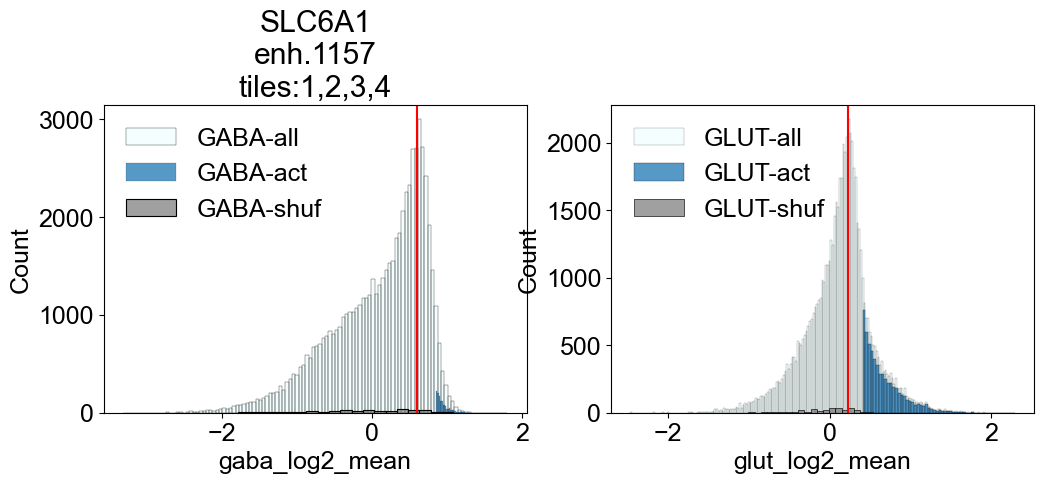

In [16]:
#for enh_id in candidate_enh_gene['enh.name'].unique():
#enh_id = "enh.1628" # ELMO - medium
#enh_id = "enh.1503" # OPRM - high
enh_id = "enh.1157" # OPRM - high

# get cell-specificity
OTHERCL = 'GABA'

CL = candidate_enh_gene.loc[candidate_enh_gene["enh.name"] == enh_id, "cell-specific"].iloc[0]
if CL == "GABA":
    OTHERCL = 'GLUT'
    
ACTMEAN_COL = f"{CL.lower()}_log2_mean"
OTHERACTMEAN_COL = f"{OTHERCL.lower()}_log2_mean"

# subset only CL-MPRA active sequences
enh = df.loc[df["enh.name"]==enh_id].drop_duplicates()
active = df.loc[df[f"{CL.lower()}-label"]=="activating", cols].drop_duplicates()

# other cell distribution
other_active = df.loc[df[f"{OTHERCL.lower()}-label"]=="activating", cols].drop_duplicates()

# shuffled distribution
shuffle = df.loc[df["name"].str.contains("shuf"), cols]

# subset active tiles from candidate enhancer
#enh = active.loc[active["enh.name"]==enh_id].drop_duplicates()

# get candidate tiles inside the enhancer. 
can_list= set(enh["candidate_list"].dropna())

#if len(can_list)>0:
for l in can_list:

    gene = candidate_enh_gene.loc[candidate_enh_gene["enh.name"]==enh_id, "gene"].iloc[0]
    enh_coor= candidate_enh_gene.loc[candidate_enh_gene["enh.name"]==enh_id, "enh.id"].iloc[0]
    
    other_enh = other_active.loc[other_active["enh.name"]==enh_id].drop_duplicates()
    
    ## plot mean section activity in activity distribution for each cell types
    
    sns.despine()
    fig, (ax1, ax2)=plt.subplots(ncols = 2, figsize = (12,4))

    
    # CELLTYPE ONE
    sns.histplot(x=ACTMEAN_COL, data=df, ax=ax1, color = "#d0fefe", alpha=0.2, label = f"{CL}-all") # full data distribution
    sns.histplot(x=ACTMEAN_COL, data=active, ax=ax1, label = f"{CL}-act")  # active elements only
    sns.histplot(x=ACTMEAN_COL, data=shuffle, ax=ax1, color="grey", bins=20, label = f"{CL}-shuf")  # active elements only
    
    # CELLTYPE TWO
    sns.histplot(x=OTHERACTMEAN_COL, data=df, ax=ax2, color = "#d0fefe", alpha=0.2, label = f"{OTHERCL}-all")  # full data distribution
    sns.histplot(x=OTHERACTMEAN_COL, data=other_active, ax=ax2, label = f"{OTHERCL}-act")  # active elements only
    sns.histplot(x=OTHERACTMEAN_COL, data=shuffle, ax=ax2, color="grey", bins=20, label = f"{OTHERCL}-shuf")  # active elements only
    
    
    mean_candidate = df.loc[(df["enh.name"]==enh_id)&
                            (df["candidate"] ==True) &
                            (df["tile.order"].isin([int(i) for i in l.split(",")])),
                            ACTMEAN_COL].mean()
    
    mean_other = df.loc[(df["enh.name"]==enh_id)&
                        (df["candidate"] ==True)&
                        (df["tile.order"].isin([int(i) for i in l.split(",")])),
                        OTHERACTMEAN_COL].mean()
    
    ax1.axvline(mean_candidate, color="r")
    ax2.axvline(mean_other, color="r")
    
    ax1.set(title = f"{gene}\n{enh_id}\ntiles:{l}")
    ax1.legend(frameon=False)
    ax2.legend(frameon=False)
    out = os.path.join(RE, f"{gene}.{enh_id}.{l}.{CL}.activity.dist.pdf")
    if os.path.exists(out) is False:
        print("saving", enh_id, l, CL)
        plt.savefig(out, bbox_inches="tight")
    

## activity box plot

In [36]:
stats_v_shuf = {}
for enh_id in candidate_enh_gene['enh.name'].unique():
#enh_id = "enh.1628" # ELMO - medium
#enh_id = "enh.1503" # OPRM - high
#enh_id = "enh.486" # GABA
    
    # get cell-specificity
    OTHERCL = 'GABA'
    
    CL = candidate_enh_gene.loc[candidate_enh_gene["enh.name"] == enh_id, "cell-specific"].iloc[0]
    if CL == "GABA":
        OTHERCL = 'GLUT'
        palette = plt.cm.Set3.colors[2:]
        swarmpalette=plt.cm.Dark2.colors[:]
        
        
    else:
        palette = plt.cm.Set3.colors[:]
        swarmpalette=plt.cm.Dark2.colors[3:]
        
    pointcolor = "orange"
    
    ACTMEAN_COL = f"{CL.lower()}_log2_mean"
    OTHERACTMEAN_COL = f"{OTHERCL.lower()}_log2_mean"
    
    # subset only CL-MPRA active sequences
    active = df.loc[df[f"{CL.lower()}-label"]=="activating", cols].drop_duplicates()
    
    # other cell distribution
    other_active = df.loc[df[f"{OTHERCL.lower()}-label"]=="activating", cols].drop_duplicates()
    
    test = pd.concat([active, other_active])
    
    # shuffled distribution
    shuffle = df.loc[df["name"].str.contains("shuf"), cols]
    
    # subset active tiles from candidate enhancer
    enh = df.loc[df["enh.name"]==enh_id, cols].drop_duplicates()
    
    can_list= list(set(enh["candidate_list"].dropna()))
#    if len(can_list)>0:
    for can_part_list in can_list:
        if len(can_part_list.split(","))>1:
            candidate_spec= enh.loc[(enh["candidate"] ==True) &
                                     (enh["candidate_list"]==can_part_list), [ACTMEAN_COL]]
        
            candidate_spec["group"]= ACTMEAN_COL
            candidate_spec.rename(columns = {ACTMEAN_COL: "value"}, inplace=True)
            candidate_other =enh.loc[(enh["candidate"] ==True) &
                                     (enh["candidate_list"]==can_part_list),[OTHERACTMEAN_COL]]
            
            candidate_other.rename(columns = {OTHERACTMEAN_COL: "value"}, inplace=True)
            candidate_other["group"]= OTHERACTMEAN_COL
            
            gene = candidate_enh_gene.loc[candidate_enh_gene["enh.name"]==enh_id, "gene"].iloc[0]
            enh_coor= candidate_enh_gene.loc[candidate_enh_gene["enh.name"]==enh_id, "enh.id"].iloc[0]
    
            s, p_tiles_v_shuf = stats.mannwhitneyu(list(candidate_spec['value'].dropna()), 
                                                                       list(shuffle[ACTMEAN_COL].dropna()))
            s, p_othertiles_v_shuf = stats.mannwhitneyu(list(candidate_other['value'].dropna()), 
                                                                            list(shuffle[OTHERACTMEAN_COL].dropna()))
            
            # get mean of candidate tile activities. 
            mean_candidate =candidate_spec.groupby("group")["value"].mean().iloc[0]#.reset_index()
            mean_shuf = shuffle[ACTMEAN_COL].dropna().mean()
            mean_other = candidate_other.groupby("group")["value"].mean().iloc[0]#.reset_index()
            mean_other_shuf = shuffle[OTHERACTMEAN_COL].dropna().mean()

            # record stats
            stats_v_shuf[f'{enh_id}.{CL}'] = pd.DataFrame({"enh.id":[enh_id,enh_id],
                                                           "tile.list":[can_part_list, can_part_list],
                                                           'cl':[CL, OTHERCL], 
                                                           "mean_tiles":[mean_candidate, mean_other], 
                                                           "mean_shuf":[mean_shuf, mean_other_shuf], 
                                                           "mwu.p.tiles.v.shuf":[p_tiles_v_shuf, p_othertiles_v_shuf]
                                                          })
                                   

            #print("mean", CL, mean_candidate, "mean other", OTHERCL, mean_other)
            out = os.path.join(RE, f"{gene}.{enh_id}.{can_part_list}.{CL}.activity.violin.pdf")

            if os.path.exists(out) is False:

                sns.despine()
                # melt gaba and glut values together
                testt = pd.melt(test, id_vars = ["name"], value_vars = [ACTMEAN_COL, OTHERACTMEAN_COL], var_name="group")
                testt["type"] = "Active"
                
                # melt shuffled values
                shuft = pd.melt(shuffle, id_vars = ["name"], value_vars = [ACTMEAN_COL, OTHERACTMEAN_COL], var_name="group")
                shuft["type"] = "shuffle"
    
                # emptydataframe
                empty_candidate = pd.DataFrame({'value': [shuffle[ACTMEAN_COL].mean(), shuffle[OTHERACTMEAN_COL].mean()],
                                                'group': [ACTMEAN_COL, OTHERACTMEAN_COL], 
                                    "type":["shuffle", "shuffle"]})
                # combine all active gaba/glut and shuffled mpra
                t = pd.concat([testt, shuft]).reset_index(drop=True)
                
                
                # combine cell-specific candidate tile activities in gaba and glut
                c = pd.concat([candidate_spec, candidate_other]).reset_index(drop=True)
                c["type"]="Candidate tiles"
                c = pd.concat([c, empty_candidate]).reset_index(drop=True)
    
                # plot all active elements in gaba, glut, and background. 
                fig, ax=plt.subplots(figsize=(6,6))
                
                sns.violinplot(x = "group", y = "value", data=t, palette=palette, ax=ax, hue="type")
                
                # plot activity of candidate cell-type-specific tiles
                sns.swarmplot(x = "group", y="value", data=c, palette=swarmpalette, ax= ax,
                              linewidth=1, 
                              #alpha=0.5, 
                              size=5,
                              dodge=True, hue="type")
    
                # plot mean lines
                
                sns.boxplot( showmeans=True, 
                            meanline=True,
                            showfliers=False,
                            showbox=False,
                            showcaps=False,
                            x = "group", y="value", data=c, palette=swarmpalette, ax= ax, hue="type",
                            meanprops={'color': 'k', 'ls': '--', 'lw': 1},
                            medianprops={'visible': False},
                            #whiskerprops={'visible': False},
                            #zorder=10,
                            legend=False
                           )
                ax.set(title = f"{gene}\n{enh_id}\ntiles:{can_part_list}", 
                       xticklabels = [CL, OTHERCL, F"shuf-{CL}"], 
                      ylabel="MPRA activity", 
                       xlabel=""
                      )
                ax.legend( frameon=False, title='', bbox_to_anchor=(1,1))
                print("saving")
                plt.savefig(out, bbox_inches="tight")


In [38]:
pd.concat(stats_v_shuf.values())[["enh.id", "cl", "mean_tiles", "mwu.p.tiles.v.shuf"]]

,enh.id,cl,mean_tiles,mwu.p.tiles.v.shuf
0,enh.43,GABA,0.869224,4.480107e-03
1,enh.43,GLUT,0.033283,7.843191e-01
0,enh.74,GABA,0.739183,4.871662e-04
1,enh.74,GLUT,-0.060124,5.719092e-01
0,enh.123,GABA,0.611516,4.262020e-05
1,enh.123,GLUT,-0.031247,6.738437e-01
0,enh.486,GABA,0.785529,1.485268e-05
1,enh.486,GLUT,-0.144299,1.433297e-01
0,enh.1153,GABA,0.944104,1.853023e-02
1,enh.1153,GLUT,0.395222,2.328362e-02


In [30]:
mean_shuf

-0.059276942260177115